## Create the manual ground truth graph


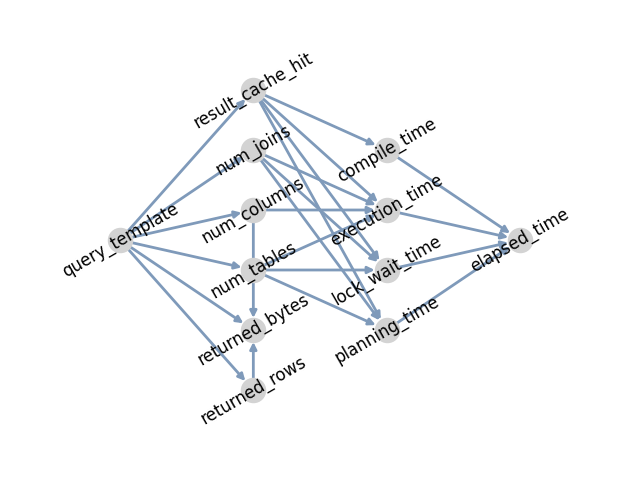

In [6]:
# Create the manual ground truth graph
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append("../scripts")
import pandas as pd
from graph_renderer import GraphRenderer

G = nx.DiGraph()


node_list = ['result_cache_hit',
 'elapsed_time',
 'query_template',
 'execution_time',
 'compile_time',
 'planning_time',
 'num_columns',
 'num_joins',
 'returned_rows',
 'lock_wait_time',
 'num_tables',
 'returned_bytes']
G.add_nodes_from(node_list)


edge_list = [( 'query_template' , 'returned_rows'),
( 'query_template' , 'returned_bytes'),
( 'returned_rows' , 'returned_bytes'),
( 'query_template' , 'num_tables'),
( 'query_template' , 'num_columns'),
( 'query_template' , 'num_joins'),

( 'num_tables' , 'planning_time'),
( 'num_joins' , 'planning_time'),
( 'num_tables' , 'lock_wait_time'),
( 'num_joins' , 'lock_wait_time'),
( 'num_tables' , 'execution_time'),
( 'num_joins' , 'execution_time'),
( 'num_columns' , 'execution_time'),
( 'num_columns' , 'returned_bytes'),


( 'query_template' , 'result_cache_hit'),
( 'result_cache_hit' , 'compile_time'),
( 'result_cache_hit' , 'planning_time'),
( 'result_cache_hit' , 'execution_time'),
( 'result_cache_hit' , 'lock_wait_time'),


( 'compile_time' , 'elapsed_time'),
( 'planning_time' , 'elapsed_time'),
( 'execution_time' , 'elapsed_time'),
( 'lock_wait_time' , 'elapsed_time'),
]

G.add_edges_from(edge_list)

# Save the graph as png
vars_dict = {n:n for n in node_list}
GraphRenderer.save_graph(
    G, vars_dict, f"/home/markakis/tpc-ds-postgres-queries/causal-discovery/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual.png"
)

# Write out graph as pickle
with open(f"/home/markakis/tpc-ds-postgres-queries/causal-discovery/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual.pkl", "wb") as f:
    pickle.dump(G, f)

GraphRenderer.display_graph(G, vars_dict)


---

## Get the CaGreS summarized graph


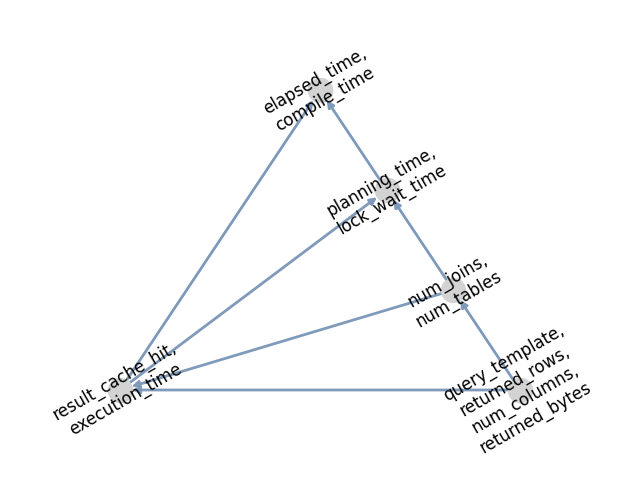

In [16]:
import networkx as nx
import sys
sys.path.append('/home/markakis/CausalDAGSummarization')
from Utils import get_recursive_basis
from Greedy import greedy
import pickle
import numpy as np
import pandas as pd

with open('/home/markakis/tpc-ds-postgres-queries/causal-discovery/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual.pkl', 'rb') as f:
    dag = pickle.load(f)

# Create a dag from `dag` where all underscores in node names are replaced by *
d = {x: x.replace("_", "*") for x in list(dag.nodes)}
dag = nx.relabel_nodes(dag, d)

k = 5
nodes = list(dag.nodes)
recursive_basis = get_recursive_basis(dag, nodes)
similarity_matrix = np.ones((len(nodes), len(nodes)))
similarity_df = pd.DataFrame(similarity_matrix, index=nodes, columns=nodes)

summary_dag_greedy, recursive_basis_greedy = greedy(dag, nodes, recursive_basis, k, similarity_df)

# Save the graph as png
vars_dict = {x: x.replace("_", ",\n").replace("*", "_") for x in list(summary_dag_greedy.nodes)}
GraphRenderer.save_graph(
    summary_dag_greedy, vars_dict, f"/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_cagres_output.png"
)


# Write out graph as pickle
with open(f"/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_cagres.output.pkl", "wb") as f:
    pickle.dump(summary_dag_greedy, f)

GraphRenderer.display_graph(summary_dag_greedy, vars_dict)


---

## Get the SSumM summarized graph

Create the inputs that SSumM expects

In [119]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from graph_renderer import GraphRenderer


with open('/home/markakis/tpc-ds-postgres-queries/causal-discovery/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual.pkl', 'rb') as f:
    G = pickle.load(f)

# Map each node to an integer and dump the mapping
orig_edges = G.edges()
orig_nodes = G.nodes()
node_to_int = {node: i for i, node in enumerate(G.nodes())}

with open('/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm_node_mapping.csv', 'w') as f:
    for node, i in node_to_int.items():
        f.write(f'{node},{i}\n')

# Dump the edges
with open('/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm_input.tsv', 'w') as f:
    for edge in G.edges():
        f.write(f'{node_to_int[edge[0]]}\t{node_to_int[edge[1]]}\n')

Run the algorithm

In [120]:
!java -cp /home/markakis/SSumM/SSumM.jar:/home/markakis/SSumM/fastutil-8.2.3.jar ssumm.SSumM "/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm_input.tsv" 0.5 1

---------------------------------------------------
Data Read Start: 2024-07-17 14:05:34
|V|: 12
|E|: 23
Finished reading the input graph
Start Time: 2024-07-17 14:05:34
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
---------------------------------------------------
Elapsed Time: 90.0 ms
Original size: 164.91 bits
Summary size: 69.01 bits (41.845826%)
L1error: 8.84e-02


In [121]:
# Move and rename the file
!mv '/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/output/summary_2024-07-03 17:36:14.txt' '/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm_output.txt'

Read back the inputs and transform them nicely


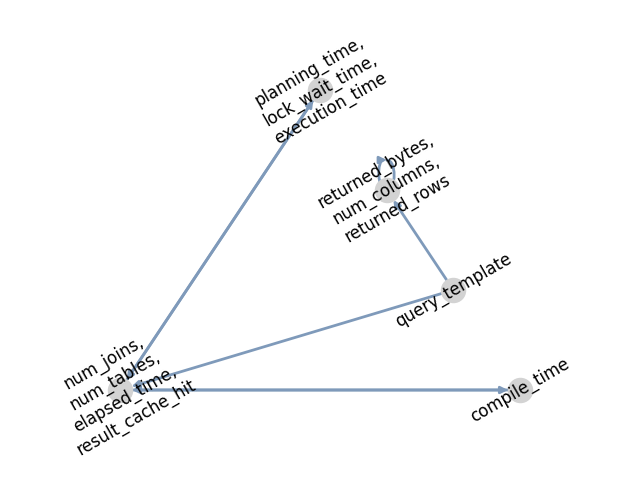

In [122]:
# Read the summarized graph from the format that SSumM outputs.


# Read the node encoding
int_to_node = {}
with open('/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm_node_mapping.csv', 'r') as f:
    for line in f:
        node, i = line.strip().split(',')
        int_to_node[int(i)] = node

# Read the nodes and edges
summ_nodes = dict()
summ_edges = []
reading_nodes = False

with open('/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm_output.txt', 'r') as f:
    for line in f:
        if line.startswith('<') and not reading_nodes:
            reading_nodes = True
            continue
        elif line.startswith('<') and reading_nodes:
            reading_nodes = False
            continue
        if reading_nodes:
            l = list(map(int, line.strip().split('\t')))
            for i in range(1, len(l)):
                l[i] = int_to_node[l[i]]
            summ_nodes[l[0]] = {'name': ',\n'.join(l[1:]), 'members': l[1:]}

            for src in summ_nodes[l[0]]:
                for tgt in summ_nodes[l[0]]:
                    if (src, tgt) in orig_edges:
                        summ_edges.append((summ_nodes[l[0]]['name'], summ_nodes[l[0]]['name']))
                    elif (tgt, src) in orig_edges:
                        summ_edges.append((summ_nodes[l[0]]['name'], summ_nodes[l[0]]['name']))
        else:
            l = list(map(int, line.strip().split('\t')))
            super_source = l[0]
            super_target = l[1]

            for src in summ_nodes[super_source]['members']:
                for tgt in summ_nodes[super_target]['members']:
                    if (src, tgt) in orig_edges:
                        summ_edges.append((summ_nodes[super_source]['name'], summ_nodes[super_target]['name']))
                    elif (tgt, src) in orig_edges:
                        summ_edges.append((summ_nodes[super_target]['name'], summ_nodes[super_source]['name']))



# Create a new graph with the summarized nodes and edges
G_summarized = nx.DiGraph()
summ_node_names = [node['name'] for node in summ_nodes.values()]
G_summarized.add_nodes_from(summ_node_names)
G_summarized.add_edges_from(summ_edges)

# Save the graph as png
vars_dict = {x: x for x in list(G_summarized.nodes)}
GraphRenderer.save_graph(
    G_summarized, vars_dict, f"/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm_output.png"
)


# Write out graph as pickle
with open(f"/home/markakis/tpc-ds-postgres-queries/causal-graph-summarization/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_manual_ssumm.output.pkl", "wb") as f:
    pickle.dump(G_summarized, f)

GraphRenderer.display_graph(G_summarized, vars_dict)
